In [28]:
import os
import numpy as np
import mne
import matplotlib.pyplot as plt  

In [29]:
current_folder = os.getcwd()
root_folder = os.path.dirname(current_folder)
print(current_folder)
print(root_folder)

C:\Users\Shizhe\brain_data\AudVisRhythm\data\code
C:\Users\Shizhe\brain_data\AudVisRhythm\data


In [30]:
# preload=True # (or string) in the constructor or raw.load_data()
subject = 'sub-004'
raw_file = os.path.join(root_folder,subject,'eeg', subject+'_task-Experiment_eeg.set')
print(raw_file)

C:\Users\Shizhe\brain_data\AudVisRhythm\data\sub-004\eeg\sub-004_task-Experiment_eeg.set


In [31]:
orig_raw = mne.io.read_raw_eeglab(raw_file)

Reading C:\Users\Shizhe\brain_data\AudVisRhythm\data\sub-004\eeg\sub-004_task-Experiment_eeg.fdt


In [32]:
# event_id = {"rt": 1, "square": 2}  # must be specified for str events
raw = mne.io.read_raw_eeglab(raw_file)
#orig_raw = raw.copy()
raw.load_data()

Reading C:\Users\Shizhe\brain_data\AudVisRhythm\data\sub-004\eeg\sub-004_task-Experiment_eeg.fdt
Reading 0 ... 809798  =      0.000 ...  3163.273 secs...


<RawEEGLAB  |  sub-004_task-Experiment_eeg.fdt, n_channels x n_times : 32 x 809799 (3163.3 sec), ~197.8 MB, data loaded>

%matplotlib inline
raw.plot_psd(fmax=150, tmax=200)
raw.plot(duration=60, start=1000, n_channels=32);

Filtering for slow drifts 

In [33]:
raw = raw.filter(l_freq=1, h_freq=55)  #l_freq=cutoff
raw = raw.notch_filter(freqs=60)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 845 samples (3.301 sec)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 

raw.plot_psd(fmax=150, tmax=200)
raw.plot(duration=60, start=1000,scalings=dict(eeg=2*20e-6), n_channels=32);

# additional info

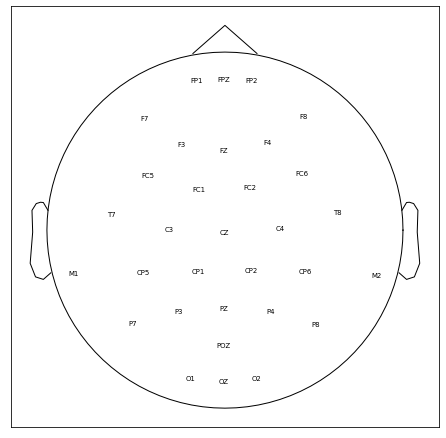

In [34]:
eeg_layout= mne.channels.find_layout(raw.info) #, ch_type='eeg')
eeg_layout.plot();

In [35]:
#print(raw.info)
print(raw.n_times); print(raw.n_times/256); print(raw.n_times/256/60);

809799
3163.27734375
52.7212890625


In [36]:
print(raw.ch_names)

['FP1', 'FPZ', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'CZ', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'PZ', 'P4', 'P8', 'POZ', 'O1', 'OZ', 'O2']


# Preprocessing 

Visualizing EOG and ECG artifact

In [37]:
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)

from importlib import reload
reload(plt)
%matplotlib notebook

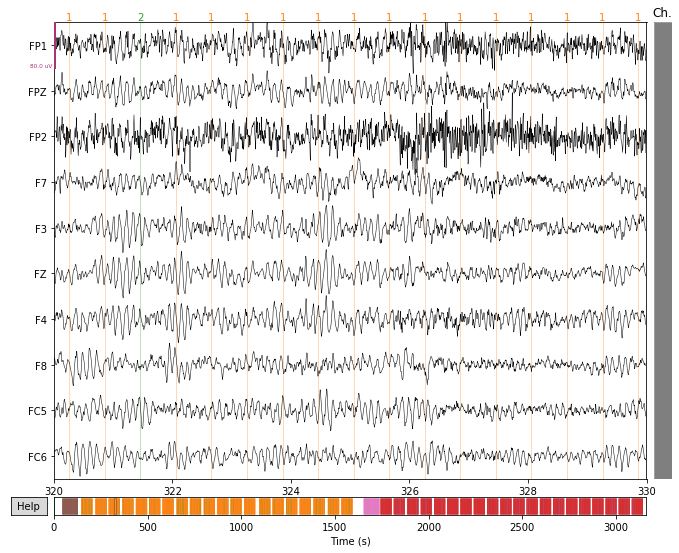

In [38]:
%matplotlib inline
regexp = 'FP.|F7|F8|F3|F4|FZ|FC5|FC6'
artifact_picks = mne.pick_channels_regexp(raw.ch_names, regexp=regexp)
raw.plot(start=320, scalings=dict(eeg=2*20e-6),order=artifact_picks, n_channels=len(artifact_picks));

In [39]:
# tried to visualize EOG epcohs but there is no EOG channel recordings, 
# but there is clear indicator of electrical noise generated by eye movement as seen from 310~330 ms
#eog_evoked = create_eog_epochs(raw).average()
#eog_evoked.apply_baseline(baseline=(None, -0.2))
#eog_evoked.plot_joint()

In [40]:
# unable to reconstract ECG channel
#ecg_evoked = create_ecg_epochs(raw).average()
#ecg_evoked.apply_baseline(baseline=(None, -0.2))
#ecg_evoked.plot_joint()

Filtering to remove slow drifts

In [41]:
#filt_raw = raw.copy()
#filt_raw.load_data().filter(l_freq=1., h_freq=None)

In [42]:
# Fitting and plotting the ICA solution

In [62]:
# set up and fit the ICA
#ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
#ica.fit(raw)
ica = ICA(n_components=20, random_state=197, max_iter=800)
ica.fit(raw)

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 20 components
Fitting ICA took 24.5s.


<ICA  |  raw data decomposition, fit (fastica): 809799 samples, 20 components, channels used: "eeg">

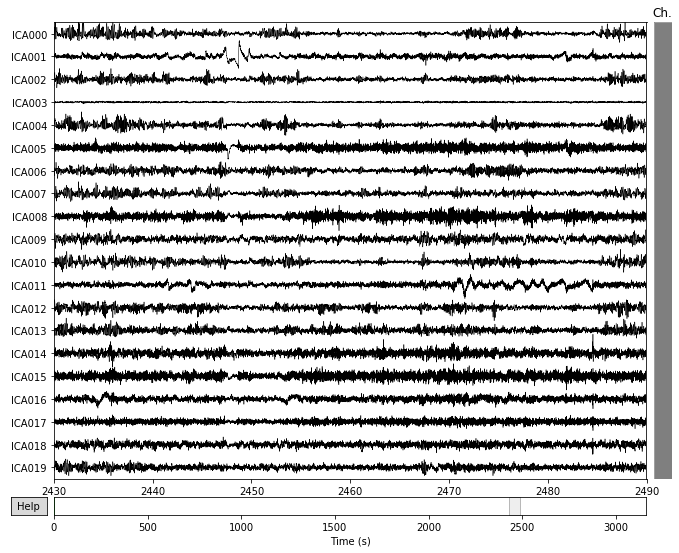

In [63]:
%matplotlib inline
ica_time = 2430
ica.plot_sources(raw, start=ica_time, stop=ica_time+60);  # raw);

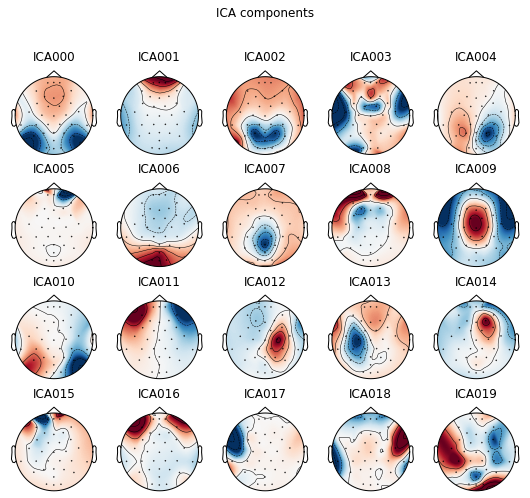

In [64]:
ica.plot_components();

    Using multitaper spectrum estimation with 7 DPSS windows
1581 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
1581 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


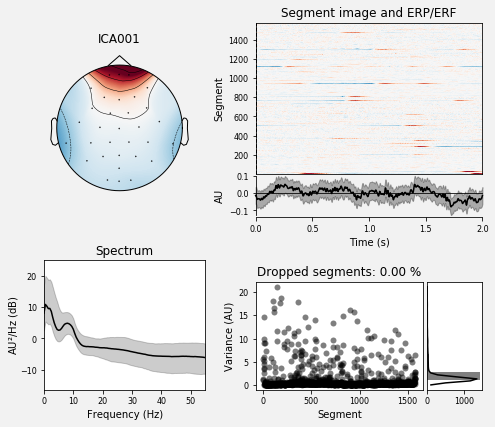

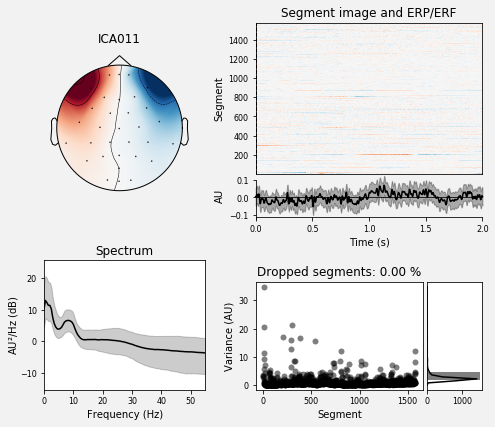

In [65]:
%matplotlib inline
#import matplotlib.pyplot as plt
#plt.tight_layout() 
#ica.exclude = [1, 5, 8]
ica.plot_properties(raw, picks=[1,11],psd_args=dict(fmax=55));
#ica.plot_properties(filt_raw, picks=[1, 5, 8, 11, 9, 10]);

likely heaert beat component

In [66]:
# a brain component as seen from the strong 10 Hz peak, 9% residual variance of the single dipole model, and roughly dipolar scalp topography.

ica.plot_properties(raw, picks=[0, 3],psd_args=dict(fmax=55));

This components captures the effects of eye blinks. This is most clearly visible in the time series plot but can also be seen in the ERP Image. The scalp topography shows that the component affects the electrodes around the eyes, roughly equally.

Also, line noise is contamination from the alternating current that is used to power nearly all lighting fixtures and electronics these days. 60 Hz.

To avoid issues with this type of noise, many datasets are passed through a notch filter centered at either 50 Hz or 60 Hz. This will cause a sharp dip in the power spectrum at that frequency and is not indicative of any of these categories.

005: This components captures the effects of horizontal eye movement

ica.plot_properties(raw, picks=[6, 8],psd_args=dict(fmax=55));

This component is most readily recognized by the power spectrum as it has low amounts of low frequency power and high amounts of broad band high frequency power. The dipoles are also located very close to the outside of the skull. Even though the component has high residual variance, the scalp topography a pattern that can easily be interpreted to be a very shallow dipole.

In [67]:
#ica.plot_properties(filt_raw, picks=[3,4],psd_args=dict(fmax=100));

However, there are no clear indicator for a heart components with different settings for ICA

In [68]:
ica.exclude = [1,11]

Transforming to ICA space (20 components)
Zeroing out 3 ICA components


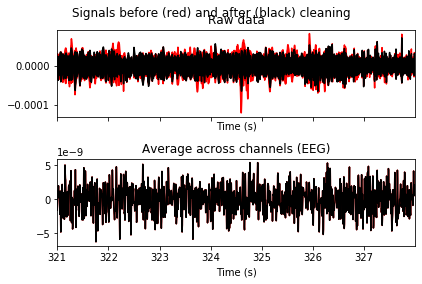

In [69]:
# blinks
plot_start = 321
ica.plot_overlay(raw, exclude=[0,1], start=plot_start*256, stop=(plot_start+7)*256);

Transforming to ICA space (20 components)
Zeroing out 2 ICA components


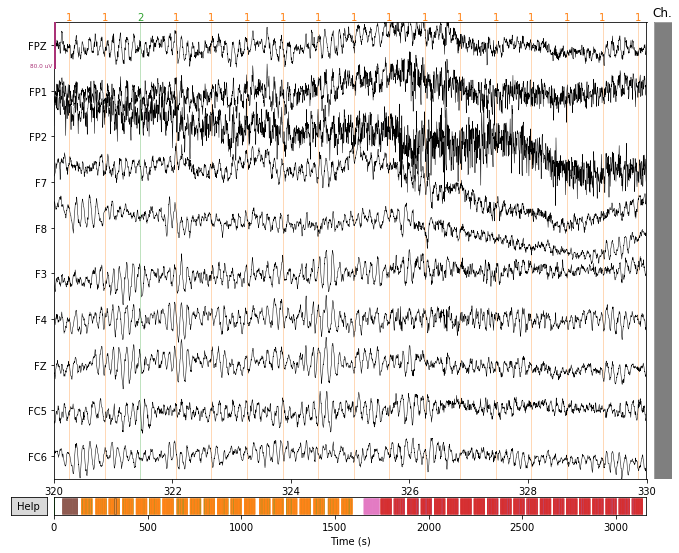

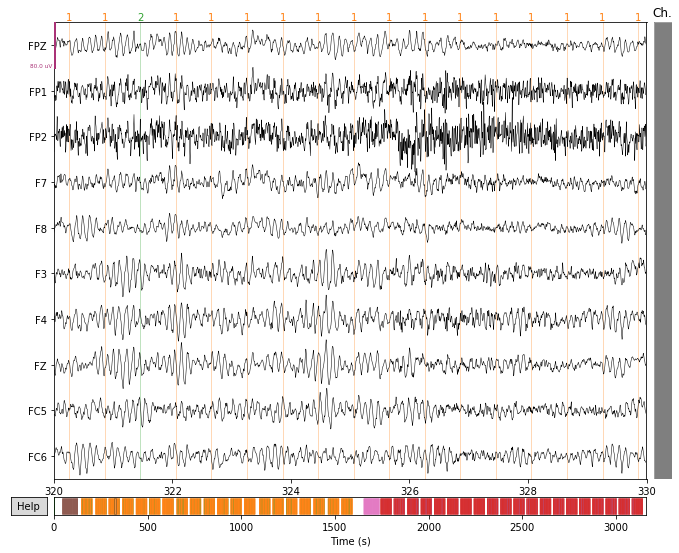

In [70]:
#orig_raw = raw.copy()
raw.load_data()
ica.apply(raw)
# show some frontal channels to clearly illustrate the artifact removal
chs = ['FPZ','FP1','FP2','F7','F8','F3','F4','FZ','FC5','FC6']
chan_idxs = [raw.ch_names.index(ch) for ch in chs]
orig_raw.plot(start=320, scalings=dict(eeg=2*20e-6),order=chan_idxs, n_channels=len(chan_idxs))
raw.plot(start=320, scalings=dict(eeg=2*20e-6),order=chan_idxs, n_channels=len(chan_idxs));

In [71]:
del orig_raw

In [72]:
raw.save(subject+'_eeg_processed_raw.fif')

Writing C:\Users\Shizhe\brain_data\AudVisRhythm\data\code\sub-004_eeg_processed_raw.fif
Closing C:\Users\Shizhe\brain_data\AudVisRhythm\data\code\sub-004_eeg_processed_raw.fif [done]
